In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


PRODUCTS_FOLDER = 'Products/'
TRANSACTIONS_FOLDER = 'Transactions/'

categories_df = pd.read_csv(os.path.join(PRODUCTS_FOLDER, 'Categories.csv'), sep='|', header=None, names=['category_id', 'category_name'])

product_category_df = pd.read_csv(os.path.join(PRODUCTS_FOLDER, 'ProductCategory.csv'), sep='|')

transaction_files = glob(os.path.join(TRANSACTIONS_FOLDER, '*_Tran.csv'))
transactions_dfs = []

for file in transaction_files:
    df = pd.read_csv(file, sep='|', header=None, names=['date', 'store_id', 'customer_id', 'products'])
    df['products'] = df['products'].str.split(' ')  # Convertir la cadena de productos en lista
    transactions_dfs.append(df)
    

all_transactions_df = pd.concat(transactions_dfs, ignore_index=True)

# Convertir listas de productos a tuplas para que sean hashables (para chequeo de duplicados)
all_transactions_df['products'] = all_transactions_df['products'].apply(tuple)

all_transactions_df['date'] = pd.to_datetime(all_transactions_df['date'])

all_transactions_df['num_products'] = all_transactions_df['products'].apply(len)

# expandir los productos en filas nuevas
exploded_products = all_transactions_df.explode('products')
exploded_products['product_id'] = pd.to_numeric(exploded_products['products'], errors='coerce')  # Convertir a numérico

# Merge con categorías de productos (asumiendo que 'v.Code_pr' es el product_id)
exploded_products = exploded_products.merge(product_category_df, left_on='product_id', right_on='v.Code_pr', how='left')
exploded_products.rename(columns={'v.code': 'category_id'}, inplace=True)

# Merge con nombres de categorías
exploded_products = exploded_products.merge(categories_df, on='category_id', how='left')


print("\n### Revisión Inicial ###\n")

# Categories.csv
print("Categories.csv:")
print(f"Número de registros: {categories_df.shape[0]}")
print("Tipos de datos:\n", categories_df.dtypes)
print("Valores faltantes:\n", categories_df.isnull().sum())
duplicates_categories = categories_df.duplicated().sum()
print(f"Duplicados: {duplicates_categories}")

# ProductCategory.csv
print("\nProductCategory.csv:")
print(f"Número de registros: {product_category_df.shape[0]}")
print("Tipos de datos:\n", product_category_df.dtypes)
print("Valores faltantes:\n", product_category_df.isnull().sum())
duplicates_product_cat = product_category_df.duplicated().sum()
print(f"Duplicados: {duplicates_product_cat}")

# Transacciones combinadas
print("\nTransacciones combinadas:")
print(f"Número de registros: {all_transactions_df.shape[0]}")
print("Tipos de datos:\n", all_transactions_df.dtypes)
print("Valores faltantes:\n", all_transactions_df.isnull().sum())
duplicates_transactions = all_transactions_df.duplicated().sum()
print(f"Duplicados: {duplicates_transactions}")



### Revisión Inicial ###

Categories.csv:
Número de registros: 50
Tipos de datos:
 category_id       int64
category_name    object
dtype: object
Valores faltantes:
 category_id      0
category_name    0
dtype: int64
Duplicados: 0

ProductCategory.csv:
Número de registros: 112010
Tipos de datos:
 v.Code_pr    int64
v.code       int64
dtype: object
Valores faltantes:
 v.Code_pr    0
v.code       0
dtype: int64
Duplicados: 18473

Transacciones combinadas:
Número de registros: 1108987
Tipos de datos:
 date            datetime64[ns]
store_id                 int64
customer_id              int64
products                object
num_products             int64
dtype: object
Valores faltantes:
 date            0
store_id        0
customer_id     0
products        0
num_products    0
dtype: int64
Duplicados: 1



### Estadísticas Descriptivas ###

Variables Numéricas (Transacciones):
       num_products
count  1.108987e+06
mean   9.550872e+00
std    9.999499e+00
min    1.000000e+00
25%    3.000000e+00
50%    6.000000e+00
75%    1.200000e+01
95%    3.100000e+01
99%    4.700000e+01
max    1.280000e+02
Media: 9.550872102197772, Mediana: 6.0, Desviación Estándar: 9.999498661234517
Número de outliers en num_products (IQR): 89733
Rango permitido: [-10.50, 25.50]


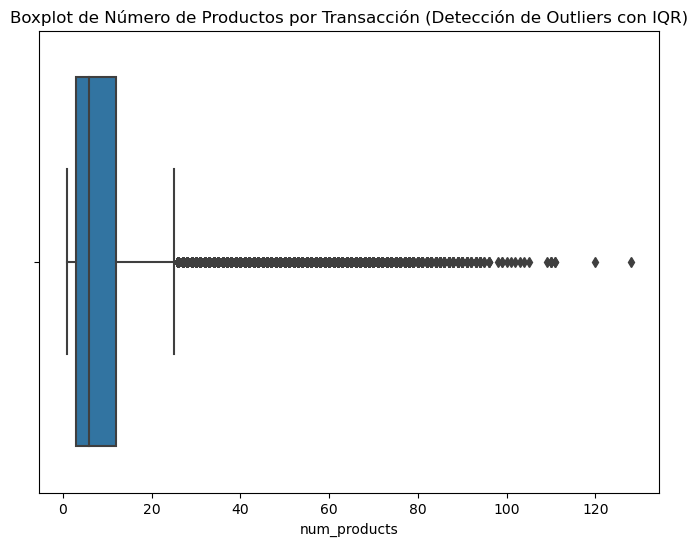


Estadísticas de Frecuencia por Cliente:
count    131186.000000
mean          8.453547
std          11.275340
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
95%          31.000000
99%          53.000000
max         535.000000
Name: freq, dtype: float64

Variables Categóricas:
Distribución de Tiendas:
 store_id
103    407130
102    314286
107    254633
110    132938
Name: count, dtype: int64

Distribución de Categorías de Productos:
 category_name
CARNES PROCESADAS AL VACIO          1811523
VERDURAS RAIZ,TUBERCULO Y BULBOS    1811523
CUIDADO DE LA ROPA                  1410750
VERDURAS DE FRUTOS                  1410750
JUGOS                                729513
VERDURAS DE HOJAS                    729513
AROMATICAS CONDIMENTOS               493388
PASTAS COMESTIBLES                   491896
AROMATICAS MEDICINALES               294753
GRUPO FRUVER-EXCEPCIONES             233546
Name: count, dtype: int64

Distribución de Productos (Top 10):
 

In [3]:
print("\n### Estadísticas Descriptivas ###\n")

print("Variables Numéricas (Transacciones):")
num_stats = all_transactions_df[['num_products']].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
print(num_stats)

# Media, Mediana, Desviación Estándar
mean_num = all_transactions_df['num_products'].mean()
median_num = all_transactions_df['num_products'].median()
std_num = all_transactions_df['num_products'].std()
print(f"Media: {mean_num}, Mediana: {median_num}, Desviación Estándar: {std_num}")

# Detección de Outliers (usando método IQR)
Q1 = all_transactions_df['num_products'].quantile(0.25)
Q3 = all_transactions_df['num_products'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = all_transactions_df[
    (all_transactions_df['num_products'] < lower_bound) |
    (all_transactions_df['num_products'] > upper_bound)
]

print(f"Número de outliers en num_products (IQR): {len(outliers)}")
print(f"Rango permitido: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Visualización de outliers (boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=all_transactions_df['num_products'])
plt.title('Boxplot de Número de Productos por Transacción (Detección de Outliers con IQR)')
plt.show()

# Otras numéricas derivadas: Frecuencia por cliente (número de transacciones por customer_id)
customer_freq = all_transactions_df['customer_id'].value_counts().reset_index(name='freq')
customer_freq.rename(columns={'customer_id': 'customer_id'}, inplace=True)  
print("\nEstadísticas de Frecuencia por Cliente:")
print(customer_freq['freq'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

# Variables Categóricas
print("\nVariables Categóricas:")

# Distribución de Tiendas (store_id)
store_dist = all_transactions_df['store_id'].value_counts()
print("Distribución de Tiendas:\n", store_dist)

# Distribución de Categorías (de productos comprados)
category_dist = exploded_products['category_name'].value_counts()
print("\nDistribución de Categorías de Productos:\n", category_dist.head(10))  # Top 10

# Distribución de Productos (top 10 más frecuentes)
product_dist = exploded_products['product_id'].value_counts()
print("\nDistribución de Productos (Top 10):\n", product_dist.head(10))


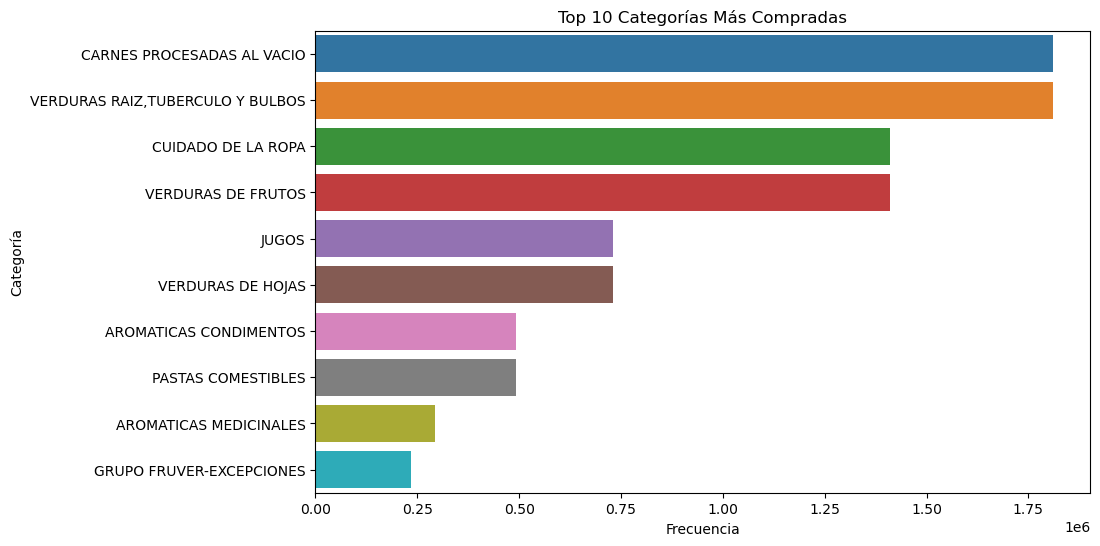

In [8]:
top_categories = category_dist.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Categorías Más Compradas')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría')
plt.show()


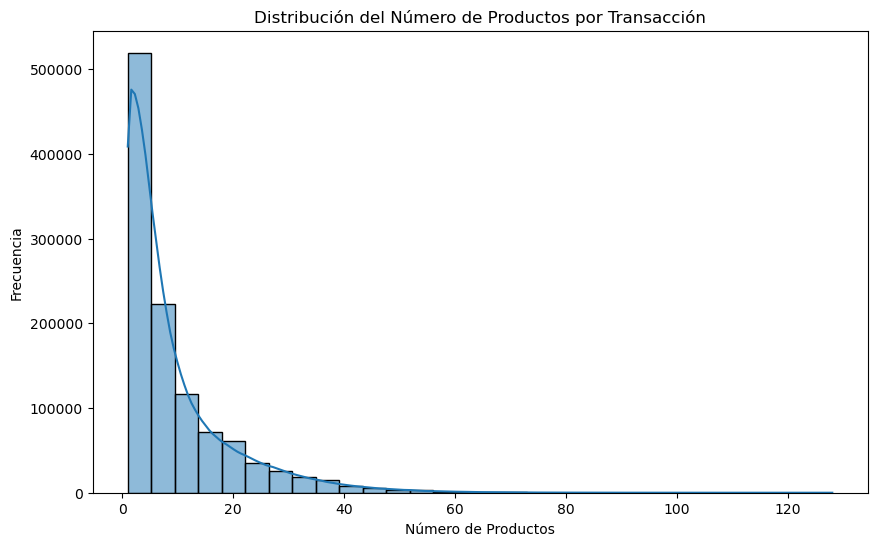

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(all_transactions_df['num_products'], bins=30, kde=True)
plt.title('Distribución del Número de Productos por Transacción')
plt.xlabel('Número de Productos')
plt.ylabel('Frecuencia')
plt.show()

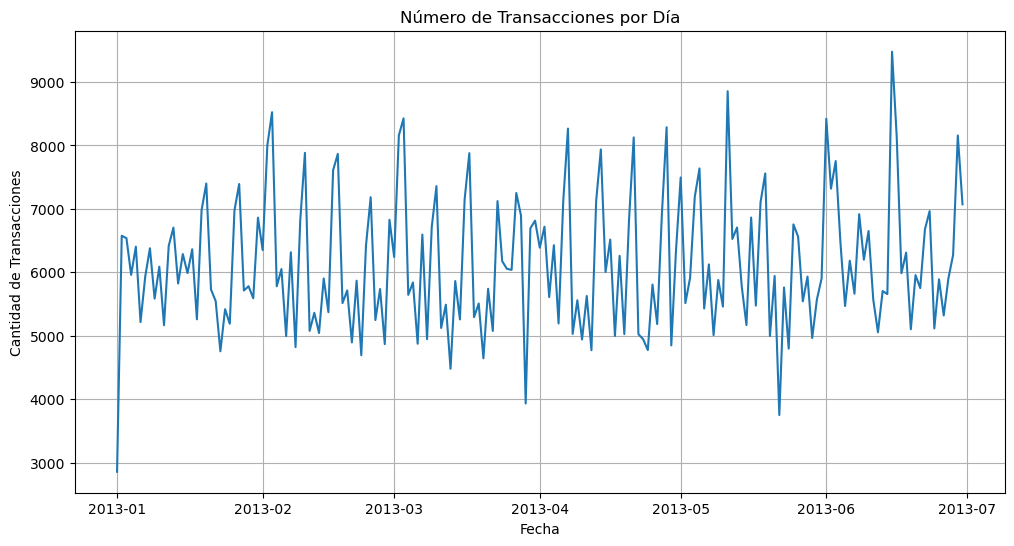

In [6]:
transactions_per_day = all_transactions_df.groupby(all_transactions_df['date'].dt.date).size()

plt.figure(figsize=(12,6))
transactions_per_day.plot()
plt.title('Número de Transacciones por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Transacciones')
plt.grid(True)
plt.show()


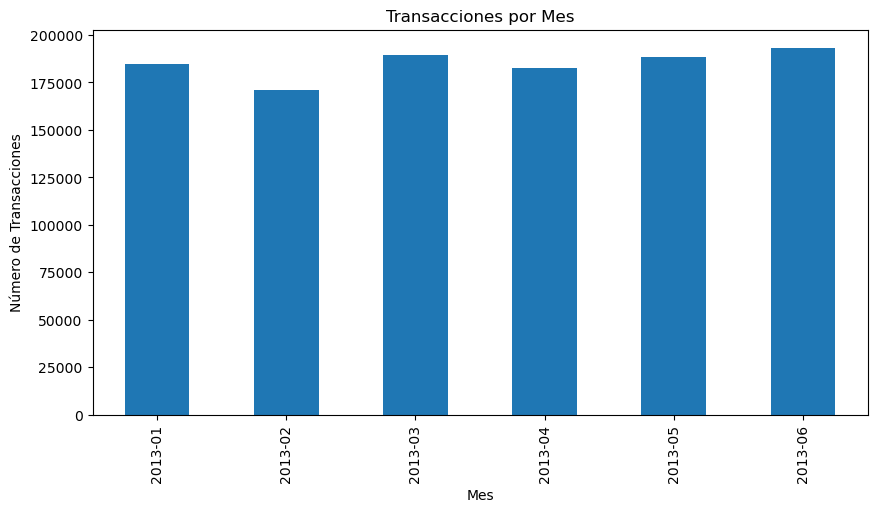

In [7]:
transactions_per_month = all_transactions_df.groupby(all_transactions_df['date'].dt.to_period('M')).size()
transactions_per_month.plot(kind='bar', figsize=(10,5), title='Transacciones por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Transacciones')
plt.show()


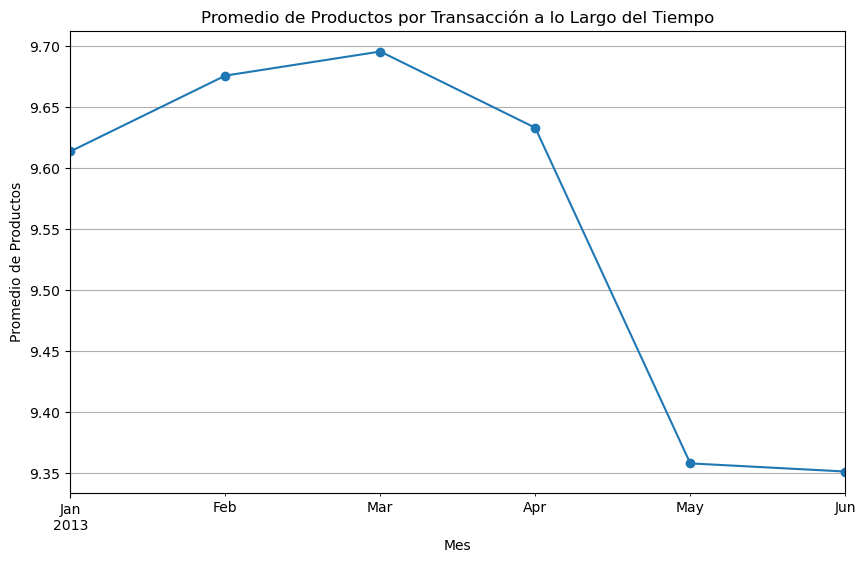

In [9]:
avg_products_over_time = all_transactions_df.groupby(all_transactions_df['date'].dt.to_period('M'))['num_products'].mean()

plt.figure(figsize=(10,6))
avg_products_over_time.plot(marker='o')
plt.title('Promedio de Productos por Transacción a lo Largo del Tiempo')
plt.xlabel('Mes')
plt.ylabel('Promedio de Productos')
plt.grid(True)
plt.show()


## Análisis 

Análisis temporal
- Ventas diarias, semanales y mensuales.
- Picos de ventas por día de la semana y hora del día.
- Tendencias y estacionalidad.

Análisis por cliente
- Frecuencia de compra.
- Tiempo promedio entre compras.
- Algún tipo de segmentación.

Análisis por producto
- Productos más vendidos.
- Investigar reglas de asociación

In [2]:
transacciones= all_transactions_df.copy()

## Análisis temporal

### Ventas diarias, semanales y mensuales

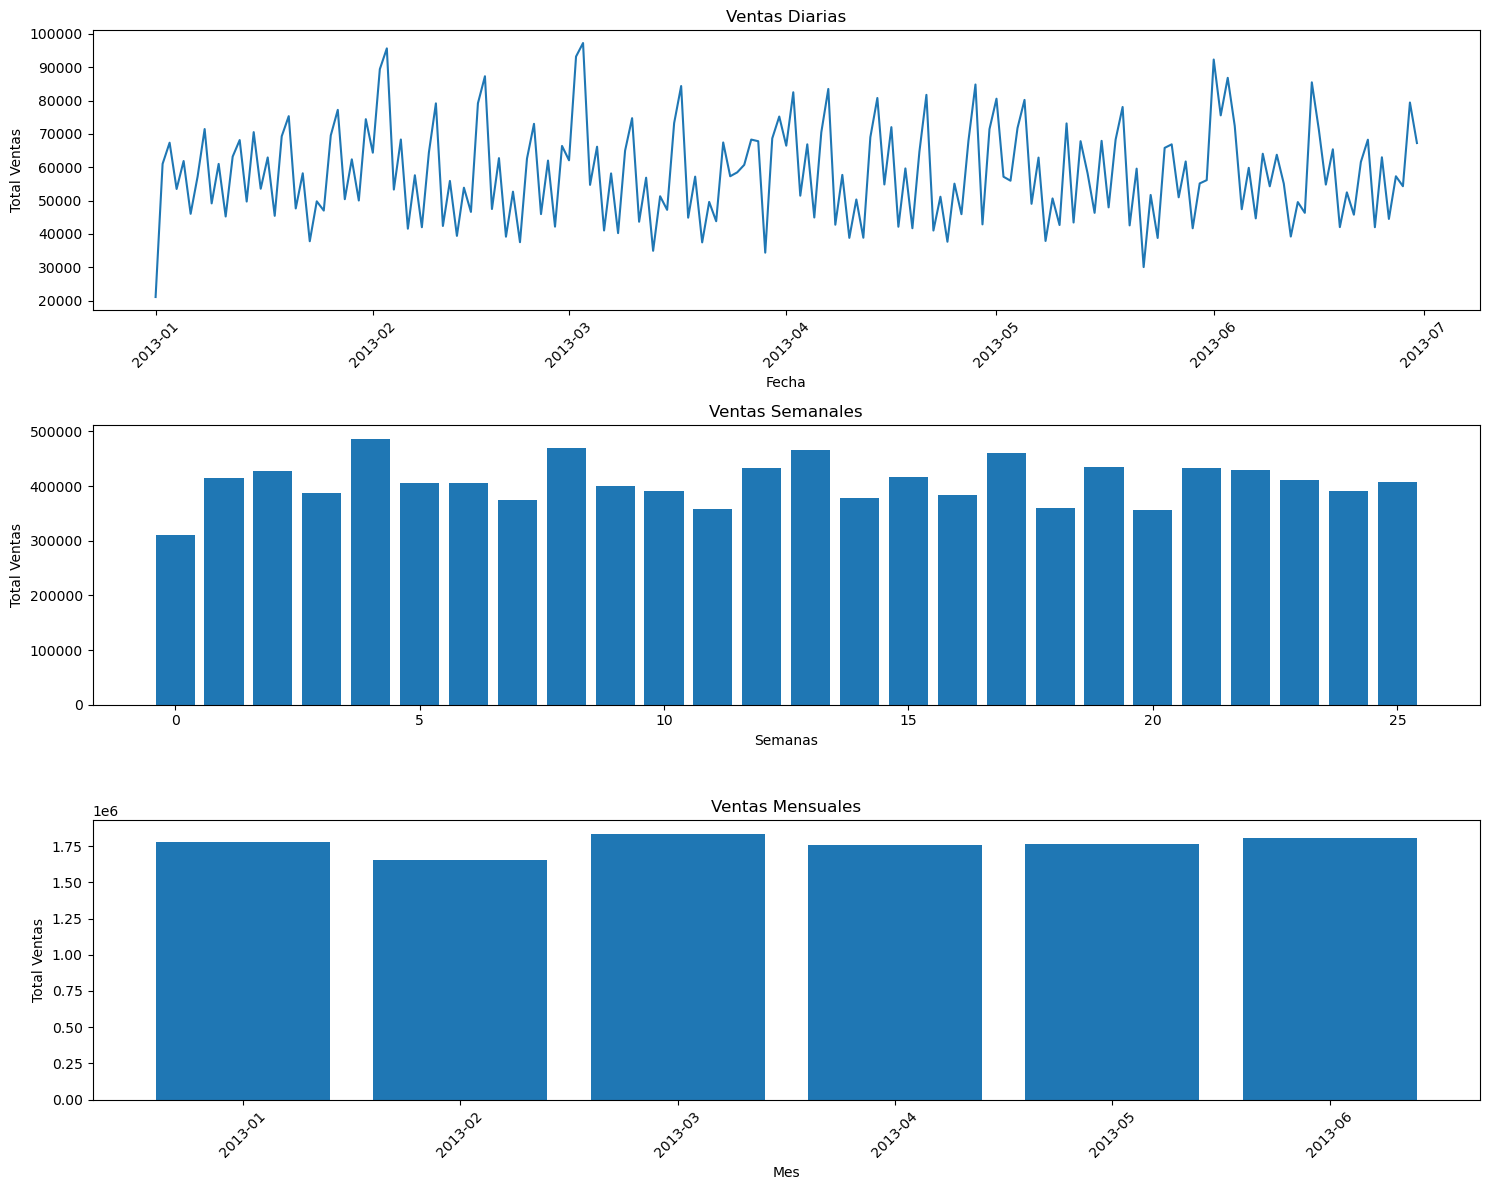

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Convertir fecha a datetime si no está en ese formato
transacciones['date'] = pd.to_datetime(transacciones['date'])

# Ventas diarias
ventas_diarias = transacciones.groupby(transacciones['date'].dt.date).agg({
    'num_products': 'sum',
    'customer_id': 'nunique'
}).rename(columns={'num_products': 'total_ventas', 'customer_id': 'clientes_unicos'})

# Ventas semanales
ventas_semanales = transacciones.groupby(transacciones['date'].dt.to_period('W')).agg({
    'num_products': 'sum',
    'customer_id': 'nunique'
}).rename(columns={'num_products': 'total_ventas', 'customer_id': 'clientes_unicos'})

# Ventas mensuales
ventas_mensuales = transacciones.groupby(transacciones['date'].dt.to_period('M')).agg({
    'num_products': 'sum',
    'customer_id': 'nunique'
}).rename(columns={'num_products': 'total_ventas', 'customer_id': 'clientes_unicos'})

# Visualización
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Diario
axes[0].plot(ventas_diarias.index, ventas_diarias['total_ventas'])
axes[0].set_title('Ventas Diarias')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Total Ventas')
axes[0].tick_params(axis='x', rotation=45)

# Semanal
axes[1].bar(range(len(ventas_semanales)), ventas_semanales['total_ventas'])
axes[1].set_title('Ventas Semanales')
axes[1].set_xlabel('Semanas')
axes[1].set_ylabel('Total Ventas')

# Mensual
axes[2].bar(ventas_mensuales.index.astype(str), ventas_mensuales['total_ventas'])
axes[2].set_title('Ventas Mensuales')
axes[2].set_xlabel('Mes')
axes[2].set_ylabel('Total Ventas')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Picos de ventas por día de la semana y hora del día.

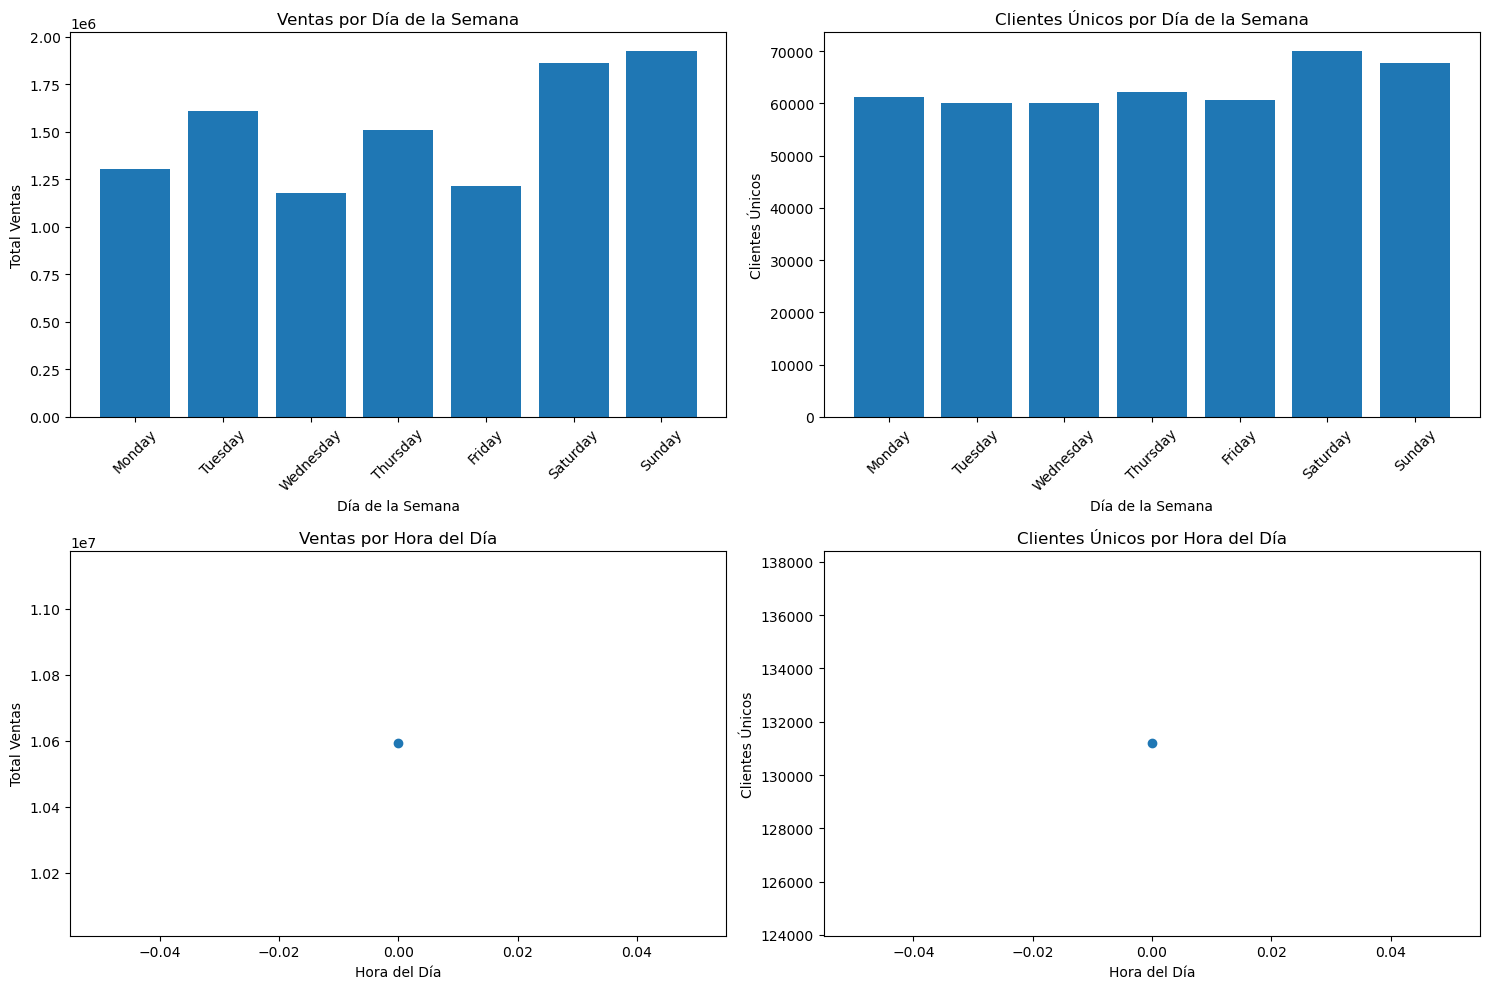

In [4]:
# Extraer día de la semana y hora
transacciones['dia_semana'] = transacciones['date'].dt.day_name()
transacciones['hora_dia'] = transacciones['date'].dt.hour

# Ventas por día de la semana
ventas_dia_semana = transacciones.groupby('dia_semana').agg({
    'num_products': 'sum',
    'customer_id': 'nunique'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Ventas por hora del día
ventas_hora_dia = transacciones.groupby('hora_dia').agg({
    'num_products': 'sum',
    'customer_id': 'nunique'
})

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ventas por día de la semana
axes[0,0].bar(ventas_dia_semana.index, ventas_dia_semana['num_products'])
axes[0,0].set_title('Ventas por Día de la Semana')
axes[0,0].set_xlabel('Día de la Semana')
axes[0,0].set_ylabel('Total Ventas')
axes[0,0].tick_params(axis='x', rotation=45)

# Clientes únicos por día de la semana
axes[0,1].bar(ventas_dia_semana.index, ventas_dia_semana['customer_id'])
axes[0,1].set_title('Clientes Únicos por Día de la Semana')
axes[0,1].set_xlabel('Día de la Semana')
axes[0,1].set_ylabel('Clientes Únicos')
axes[0,1].tick_params(axis='x', rotation=45)

# Ventas por hora del día
axes[1,0].plot(ventas_hora_dia.index, ventas_hora_dia['num_products'], marker='o')
axes[1,0].set_title('Ventas por Hora del Día')
axes[1,0].set_xlabel('Hora del Día')
axes[1,0].set_ylabel('Total Ventas')

# Clientes únicos por hora del día
axes[1,1].plot(ventas_hora_dia.index, ventas_hora_dia['customer_id'], marker='o')
axes[1,1].set_title('Clientes Únicos por Hora del Día')
axes[1,1].set_xlabel('Hora del Día')
axes[1,1].set_ylabel('Clientes Únicos')

plt.tight_layout()
plt.show()

### Tendencias y estacionalidad.

Rango de fechas: 2013-01-01 00:00:00 a 2013-06-30 00:00:00
Número de meses de datos: 6


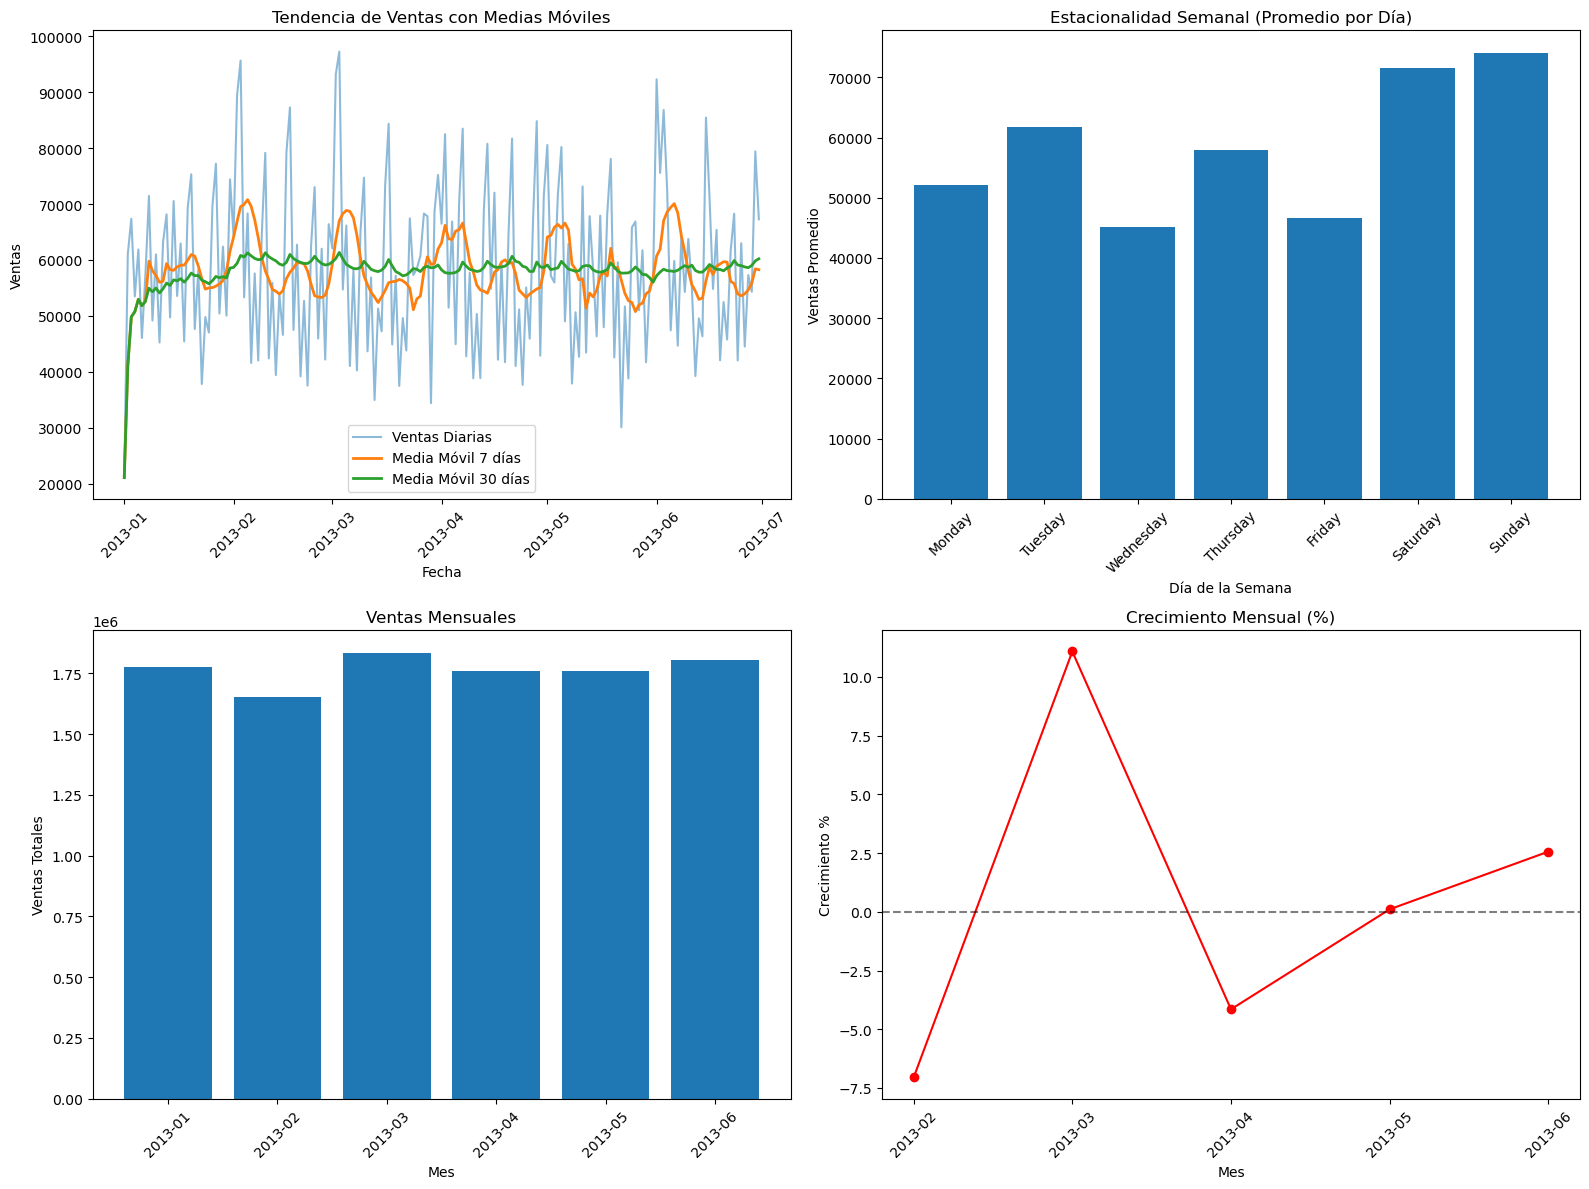

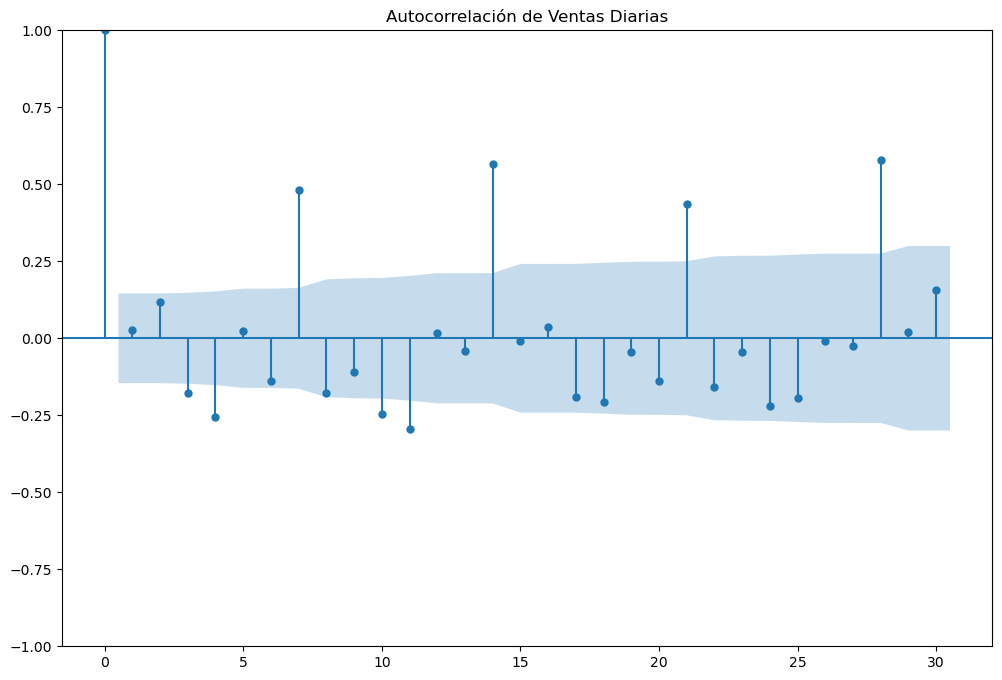

In [5]:

from statsmodels.graphics.tsaplots import plot_acf
# Preparar datos para análisis de series temporales
serie_temporal = transacciones.set_index('date')['num_products'].resample('D').sum()

print(f"Rango de fechas: {transacciones['date'].min()} a {transacciones['date'].max()}")
print(f"Número de meses de datos: {serie_temporal.resample('M').count().shape[0]}")

# Análisis alternativo para datos limitados
def analizar_tendencias_estacionalidad(serie_temporal):
    # Convertir a DataFrame para facilitar el análisis
    df_temporal = serie_temporal.reset_index()
    df_temporal.columns = ['fecha', 'ventas']

    # Extraer componentes de fecha
    df_temporal['mes'] = df_temporal['fecha'].dt.month
    df_temporal['dia_semana'] = df_temporal['fecha'].dt.day_name()
    df_temporal['semana'] = df_temporal['fecha'].dt.isocalendar().week

    # 1. Análisis de tendencia con rolling average
    df_temporal['media_movil_7d'] = df_temporal['ventas'].rolling(window=7, min_periods=1).mean()
    df_temporal['media_movil_30d'] = df_temporal['ventas'].rolling(window=30, min_periods=1).mean()

    # 2. Análisis de estacionalidad semanal
    estacionalidad_semanal = df_temporal.groupby('dia_semana')['ventas'].mean().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])

    # 3. Análisis de estacionalidad mensual (si hay datos suficientes)
    if df_temporal['mes'].nunique() >= 2:
        estacionalidad_mensual = df_temporal.groupby('mes')['ventas'].mean()
    else:
        estacionalidad_mensual = None

    return df_temporal, estacionalidad_semanal, estacionalidad_mensual

# Aplicar análisis
df_analisis, estacionalidad_semanal, estacionalidad_mensual = analizar_tendencias_estacionalidad(serie_temporal)

# Visualización de tendencias y estacionalidad
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Serie temporal con medias móviles
axes[0, 0].plot(df_analisis['fecha'], df_analisis['ventas'], alpha=0.5, label='Ventas Diarias')
axes[0, 0].plot(df_analisis['fecha'], df_analisis['media_movil_7d'], label='Media Móvil 7 días', linewidth=2)
axes[0, 0].plot(df_analisis['fecha'], df_analisis['media_movil_30d'], label='Media Móvil 30 días', linewidth=2)
axes[0, 0].set_title('Tendencia de Ventas con Medias Móviles')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Ventas')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Estacionalidad semanal
axes[0, 1].bar(estacionalidad_semanal.index, estacionalidad_semanal.values)
axes[0, 1].set_title('Estacionalidad Semanal (Promedio por Día)')
axes[0, 1].set_xlabel('Día de la Semana')
axes[0, 1].set_ylabel('Ventas Promedio')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Análisis de crecimiento mensual
ventas_mensuales = serie_temporal.resample('M').sum()
if len(ventas_mensuales) > 1:
    crecimiento_mensual = ventas_mensuales.pct_change() * 100
    axes[1, 0].bar(ventas_mensuales.index.strftime('%Y-%m'), ventas_mensuales.values)
    axes[1, 0].set_title('Ventas Mensuales')
    axes[1, 0].set_xlabel('Mes')
    axes[1, 0].set_ylabel('Ventas Totales')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Crecimiento mensual
    axes[1, 1].plot(crecimiento_mensual.index.strftime('%Y-%m'), crecimiento_mensual.values, marker='o', color='red')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Crecimiento Mensual (%)')
    axes[1, 1].set_xlabel('Mes')
    axes[1, 1].set_ylabel('Crecimiento %')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 0].text(0.5, 0.5, 'Datos insuficientes\npara análisis mensual',
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 1].text(0.5, 0.5, 'Datos insuficientes\npara análisis de crecimiento',
                   ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

# Análisis de autocorrelación para patrones
plt.figure(figsize=(12, 8))

# Autocorrelación para 15 días (2 semanas)
plot_acf(serie_temporal.dropna(), lags=min(30, len(serie_temporal)-1), ax=plt.gca())
plt.title('Autocorrelación de Ventas Diarias')
plt.show()

In [6]:
# Métricas de tendencia detalladas
def calcular_metricas_tendencia(df_analisis):
    metricas = {}

    # Tendencia lineal simple
    x = np.arange(len(df_analisis))
    y = df_analisis['ventas'].values
    slope, intercept = np.polyfit(x, y, 1)
    metricas['pendiente_tendencia'] = slope
    metricas['tendencia_diaria'] = slope / df_analisis['ventas'].mean() * 100  # % cambio diario

    # Variabilidad
    metricas['coef_variacion'] = df_analisis['ventas'].std() / df_analisis['ventas'].mean()
    metricas['ratio_pico_valle'] = df_analisis['ventas'].max() / df_analisis['ventas'].min()

    # Estacionalidad semanal
    variacion_semanal = estacionalidad_semanal.std() / estacionalidad_semanal.mean()
    metricas['fuerza_estacionalidad_semanal'] = variacion_semanal

    return metricas

metricas_tendencia = calcular_metricas_tendencia(df_analisis)

print("=== MÉTRICAS DE TENDENCIA Y ESTACIONALIDAD ===")
print(f"Pendiente de tendencia: {metricas_tendencia['pendiente_tendencia']:.2f} ventas/día")
print(f"Tendencia diaria: {metricas_tendencia['tendencia_diaria']:.2f}%")
print(f"Coeficiente de variación: {metricas_tendencia['coef_variacion']:.2f}")
print(f"Ratio pico/valle: {metricas_tendencia['ratio_pico_valle']:.2f}")
print(f"Fuerza estacionalidad semanal: {metricas_tendencia['fuerza_estacionalidad_semanal']:.2f}")

# Análisis de patrones semanales detallados
print("\n=== ANÁLISIS ESTACIONALIDAD SEMANAL ===")
for dia, ventas in estacionalidad_semanal.items():
    variacion_vs_promedio = (ventas / estacionalidad_semanal.mean() - 1) * 100
    print(f"{dia}: {ventas:.0f} ventas promedio ({variacion_vs_promedio:+.1f}% vs promedio)")

# Identificación de outliers y patrones especiales
Q1 = df_analisis['ventas'].quantile(0.25)
Q3 = df_analisis['ventas'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

outliers = df_analisis[(df_analisis['ventas'] > limite_superior) | (df_analisis['ventas'] < limite_inferior)]

print(f"\n=== DÍAS ATÍPICOS DETECTADOS ===")
print(f"Límites: {limite_inferior:.0f} - {limite_superior:.0f} ventas")
if not outliers.empty:
    for _, outlier in outliers.iterrows():
        print(f"{outlier['fecha'].strftime('%Y-%m-%d')}: {outlier['ventas']:.0f} ventas ({outlier['dia_semana']})")
else:
    print("No se detectaron días atípicos significativos")

=== MÉTRICAS DE TENDENCIA Y ESTACIONALIDAD ===
Pendiente de tendencia: 0.45 ventas/día
Tendencia diaria: 0.00%
Coeficiente de variación: 0.25
Ratio pico/valle: 4.61
Fuerza estacionalidad semanal: 0.20

=== ANÁLISIS ESTACIONALIDAD SEMANAL ===
Monday: 52070 ventas promedio (-11.0% vs promedio)
Tuesday: 61791 ventas promedio (+5.7% vs promedio)
Wednesday: 45219 ventas promedio (-22.7% vs promedio)
Thursday: 57946 ventas promedio (-0.9% vs promedio)
Friday: 46677 ventas promedio (-20.2% vs promedio)
Saturday: 71575 ventas promedio (+22.4% vs promedio)
Sunday: 74102 ventas promedio (+26.7% vs promedio)

=== DÍAS ATÍPICOS DETECTADOS ===
Límites: 13617 - 100873 ventas
No se detectaron días atípicos significativos


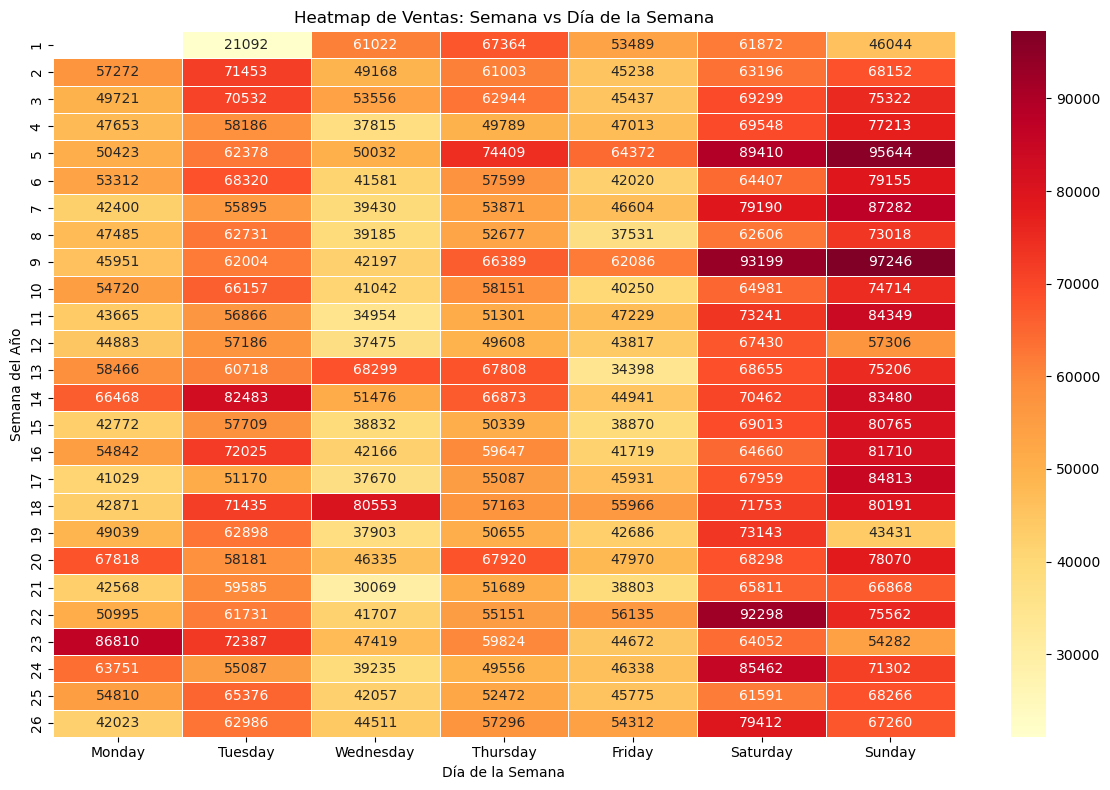

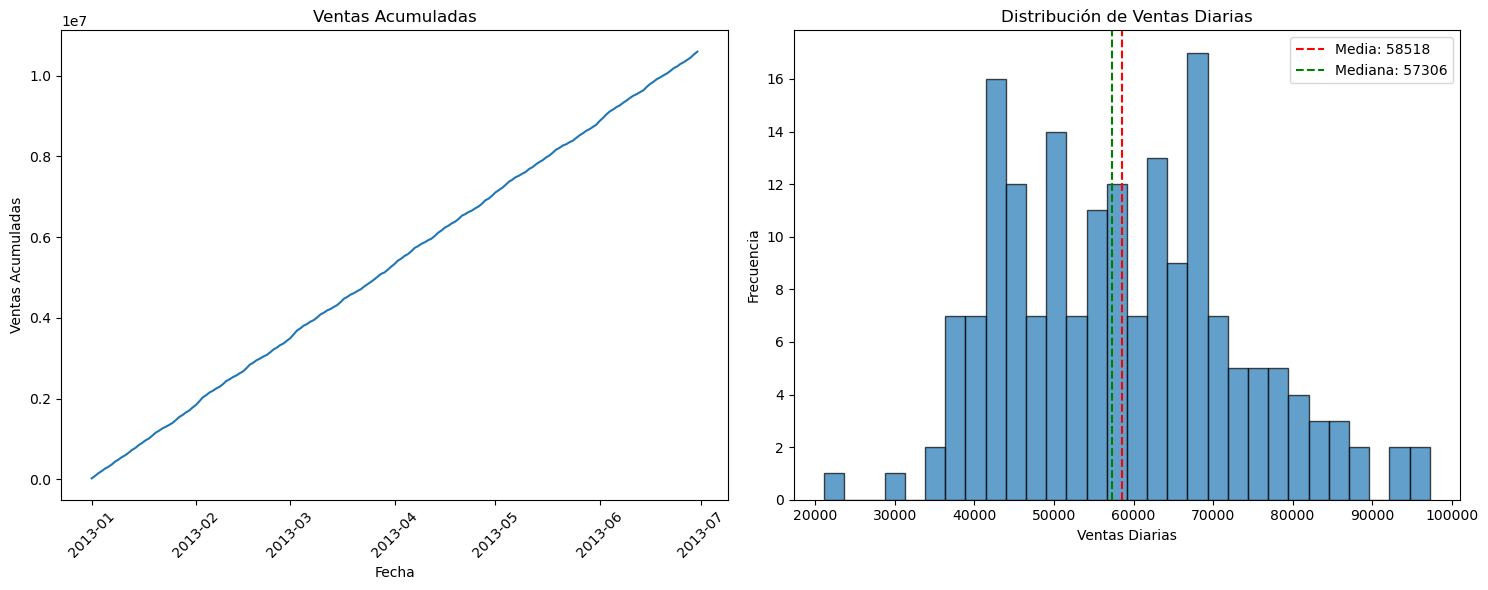

In [7]:
# Heatmap de ventas por día de semana y semana del año
if 'semana' in df_analisis.columns and df_analisis['semana'].nunique() > 1:
    # Crear heatmap semanal
    heatmap_data = df_analisis.pivot_table(
        values='ventas',
        index='semana',
        columns='dia_semana',
        aggfunc='mean'
    ).reindex(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5)
    plt.title('Heatmap de Ventas: Semana vs Día de la Semana')
    plt.xlabel('Día de la Semana')
    plt.ylabel('Semana del Año')
    plt.tight_layout()
    plt.show()

# Análisis de acumulado y tendencia
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ventas acumuladas
ventas_acumuladas = df_analisis['ventas'].cumsum()
axes[0].plot(df_analisis['fecha'], ventas_acumuladas)
axes[0].set_title('Ventas Acumuladas')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Ventas Acumuladas')
axes[0].tick_params(axis='x', rotation=45)

# Distribución de ventas diarias
axes[1].hist(df_analisis['ventas'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(df_analisis['ventas'].mean(), color='red', linestyle='--', label=f'Media: {df_analisis["ventas"].mean():.0f}')
axes[1].axvline(df_analisis['ventas'].median(), color='green', linestyle='--', label=f'Mediana: {df_analisis["ventas"].median():.0f}')
axes[1].set_title('Distribución de Ventas Diarias')
axes[1].set_xlabel('Ventas Diarias')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()

plt.tight_layout()
plt.show()

## Análisis por cliente

### Frecuencia de compra.

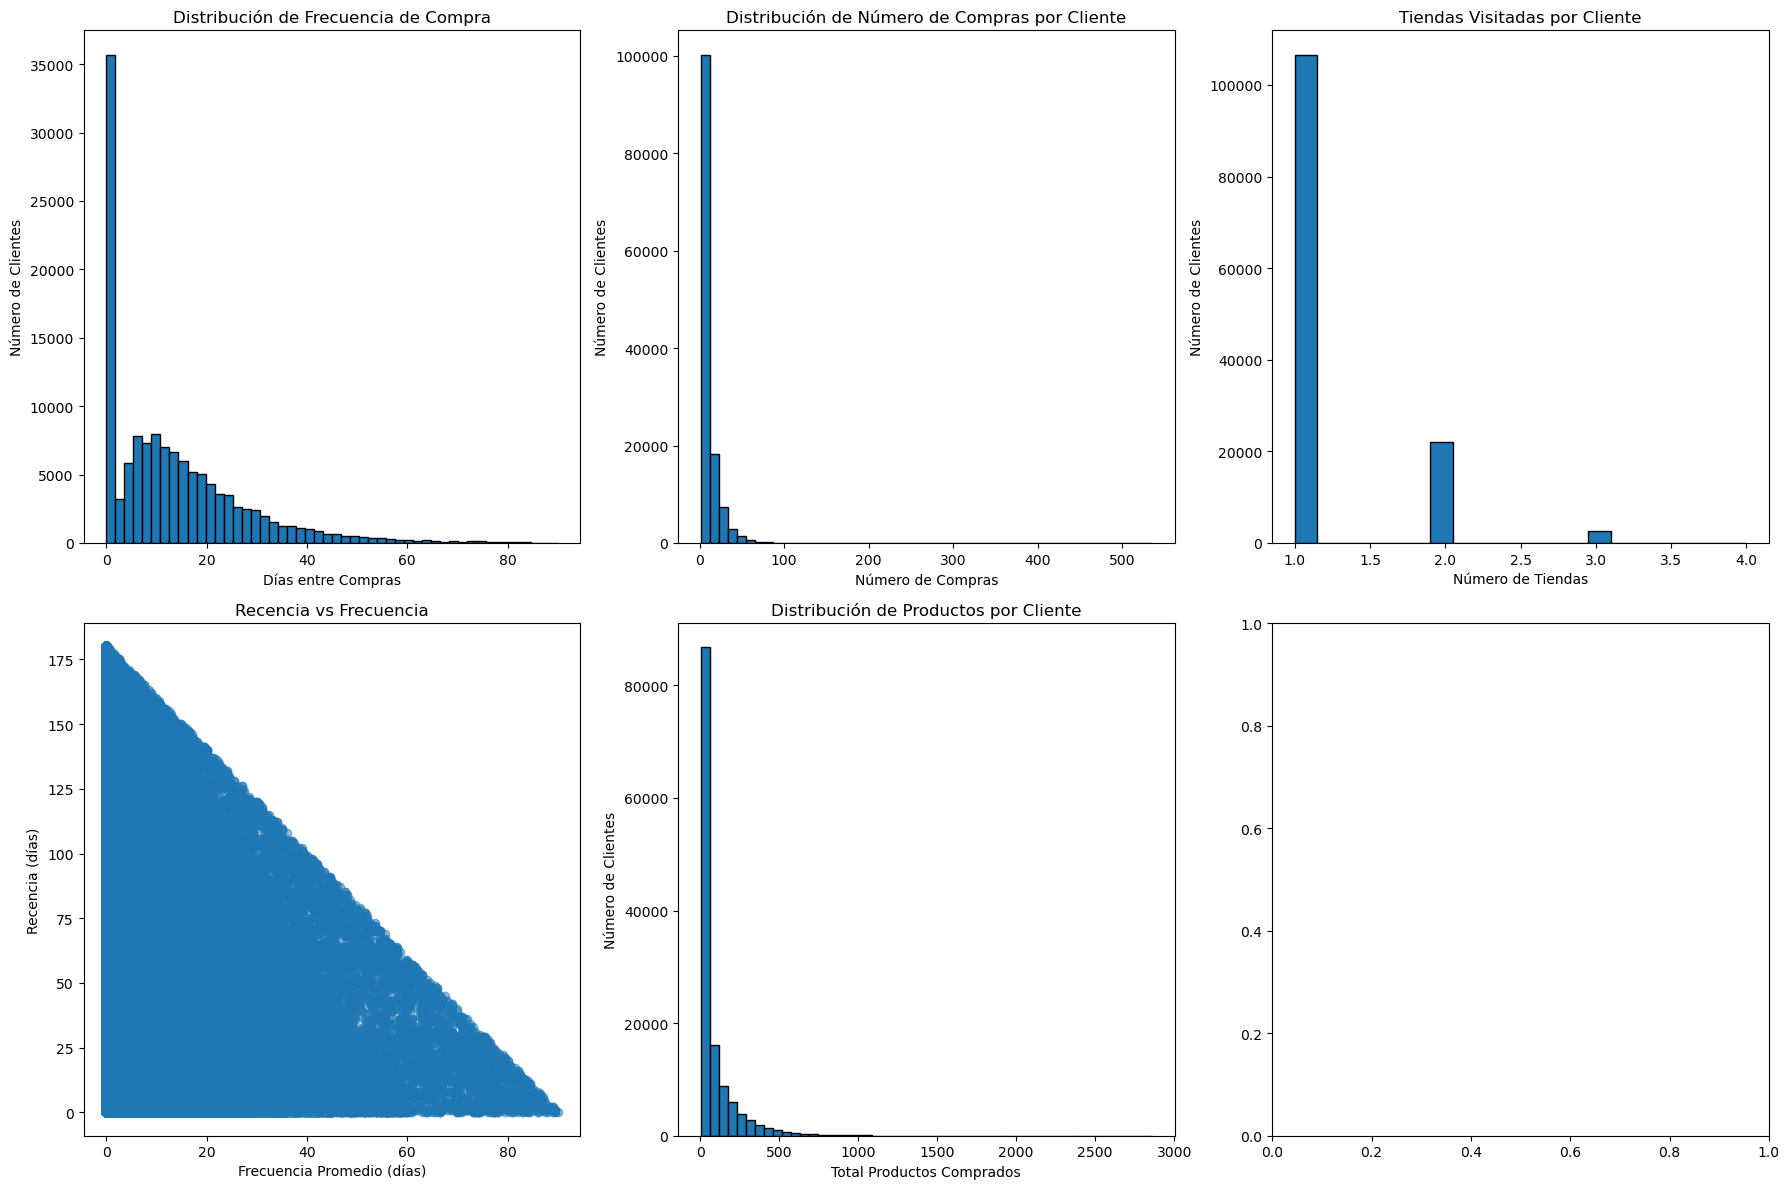

=== RESUMEN ANÁLISIS DE CLIENTES ===
Total clientes únicos: 131186
Compras promedio por cliente: 8.45
Frecuencia promedio de compra: 13.52 días
Productos promedio por cliente: 80.74
Recencia promedio: 44.47 días


In [19]:
# Análisis de comportamiento del cliente
comportamiento_cliente = transacciones.groupby('customer_id').agg({
    'date': ['count', 'min', 'max'],
    'num_products': 'sum',
    'store_id': 'nunique'
}).round(2)

comportamiento_cliente.columns = ['total_compras', 'primera_compra', 'ultima_compra', 'total_productos', 'tiendas_visitadas']

# Calcular métricas de frecuencia
comportamiento_cliente['dias_activo'] = (comportamiento_cliente['ultima_compra'] - comportamiento_cliente['primera_compra']).dt.days
comportamiento_cliente['frecuencia_promedio'] = comportamiento_cliente['dias_activo'] / comportamiento_cliente['total_compras']

# Análisis de recencia (última compra)
ultima_fecha = transacciones['date'].max()
comportamiento_cliente['recencia'] = (ultima_fecha - comportamiento_cliente['ultima_compra']).dt.days

# Visualización del análisis de clientes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de frecuencia de compra
axes[0,0].hist(comportamiento_cliente['frecuencia_promedio'].dropna(), bins=50, edgecolor='black')
axes[0,0].set_title('Distribución de Frecuencia de Compra')
axes[0,0].set_xlabel('Días entre Compras')
axes[0,0].set_ylabel('Número de Clientes')

# Distribución de número de compras
axes[0,1].hist(comportamiento_cliente['total_compras'], bins=50, edgecolor='black')
axes[0,1].set_title('Distribución de Número de Compras por Cliente')
axes[0,1].set_xlabel('Número de Compras')
axes[0,1].set_ylabel('Número de Clientes')

# Recencia vs Frecuencia
axes[1,0].scatter(comportamiento_cliente['frecuencia_promedio'], comportamiento_cliente['recencia'], alpha=0.5)
axes[1,0].set_title('Recencia vs Frecuencia')
axes[1,0].set_xlabel('Frecuencia Promedio (días)')
axes[1,0].set_ylabel('Recencia (días)')

# Distribución de productos por cliente
axes[1,1].hist(comportamiento_cliente['total_productos'], bins=50, edgecolor='black')
axes[1,1].set_title('Distribución de Productos por Cliente')
axes[1,1].set_xlabel('Total Productos Comprados')
axes[1,1].set_ylabel('Número de Clientes')

# Tiendas visitadas por cliente
axes[0,2].hist(comportamiento_cliente['tiendas_visitadas'], bins=20, edgecolor='black')
axes[0,2].set_title('Tiendas Visitadas por Cliente')
axes[0,2].set_xlabel('Número de Tiendas')
axes[0,2].set_ylabel('Número de Clientes')

plt.tight_layout()
plt.show()

# Métricas resumen del análisis de clientes
print("=== RESUMEN ANÁLISIS DE CLIENTES ===")
print(f"Total clientes únicos: {len(comportamiento_cliente)}")
print(f"Compras promedio por cliente: {comportamiento_cliente['total_compras'].mean():.2f}")
print(f"Frecuencia promedio de compra: {comportamiento_cliente['frecuencia_promedio'].mean():.2f} días")
print(f"Productos promedio por cliente: {comportamiento_cliente['total_productos'].mean():.2f}")
print(f"Recencia promedio: {comportamiento_cliente['recencia'].mean():.2f} días")

### Tiempo promedio entre compras

In [10]:
all_transactions_df = all_transactions_df.sort_values(by=['customer_id', 'date'])
all_transactions_df['prev_date'] = all_transactions_df.groupby('customer_id')['date'].shift()
all_transactions_df['days_between'] = (all_transactions_df['date'] - all_transactions_df['prev_date']).dt.days

avg_purchase_interval = all_transactions_df.groupby('customer_id')['days_between'].mean()

print("\nTiempo promedio entre compras (días):")
print(avg_purchase_interval.describe())



Tiempo promedio entre compras (días):
count    96673.000000
mean        26.389529
std         25.837758
min          0.000000
25%          9.888889
50%         18.000000
75%         32.600000
max        180.000000
Name: days_between, dtype: float64


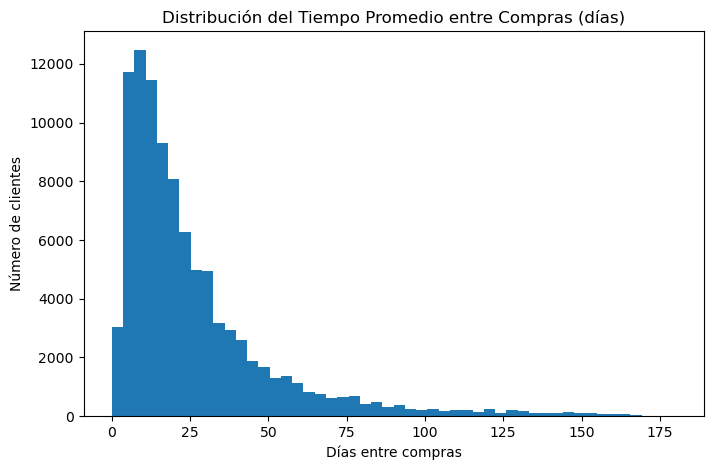

In [4]:
plt.figure(figsize=(8,5))
plt.hist(avg_purchase_interval.dropna(), bins=50)
plt.title("Distribución del Tiempo Promedio entre Compras (días)")
plt.xlabel("Días entre compras")
plt.ylabel("Número de clientes")
plt.show()

### Segmentación

avg_purchase_interval representa el promedio de días que un cliente tarda entre una compra y la siguiente, indicando qué tan frecuentemente realiza compras a lo largo del tiempo.

**Segmentación por Frecuencia**: clasifica a los clientes según cuántas compras han realizado, desde los que compran pocas veces (“Ocasional”) hasta los que compran con mucha regularidad (“Muy Frecuente”).

**Segmentación por Intervalo de Compra**: clasifica a los clientes según cada cuánto tiempo compran en promedio, desde los que compran con muy poca distancia entre compras (“Muy Frecuente”) hasta los que pasan largos periodos sin comprar (“Ocasional”).

In [22]:
# Calcular frecuencia de compra por cliente
customer_freq = all_transactions_df['customer_id'].value_counts().reset_index(name='freq')

# Calcular intervalo promedio entre compras
customer_segments = pd.DataFrame({
    "freq": customer_freq.set_index('customer_id')['freq'],
    "avg_purchase_interval": all_transactions_df.groupby('customer_id')['days_between'].mean()
})

# Segmentación por frecuencia
customer_segments['freq_segment'] = pd.cut(
    customer_segments['freq'],
    bins=[0, 2, 5, 10, 1000],
    labels=["Ocasional", "Moderado", "Frecuente", "Muy Frecuente"]
)

# Segmentación por intervalo de compra (valores altos = menos frecuente)
customer_segments['interval_segment'] = pd.cut(
    customer_segments['avg_purchase_interval'],
    bins=[0, 5, 15, 30, 1000],
    labels=["Muy Frecuente", "Frecuente", "Moderado", "Ocasional"]
)

print("\nSegmentación de Clientes (Frecuencia):")
print(customer_segments['freq_segment'].value_counts())

print("\nSegmentación de Clientes (Intervalo de Compra):")
print(customer_segments['interval_segment'].value_counts())



Segmentación de Clientes (Frecuencia):
freq_segment
Ocasional        50695
Muy Frecuente    33822
Moderado         25379
Frecuente        21290
Name: count, dtype: int64

Segmentación de Clientes (Intervalo de Compra):
interval_segment
Frecuente        33819
Moderado         28625
Ocasional        27176
Muy Frecuente     7034
Name: count, dtype: int64


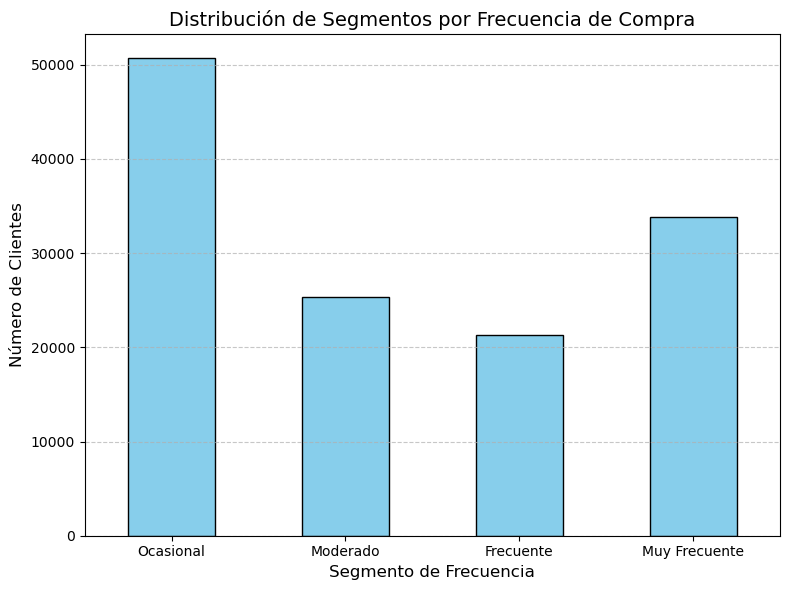

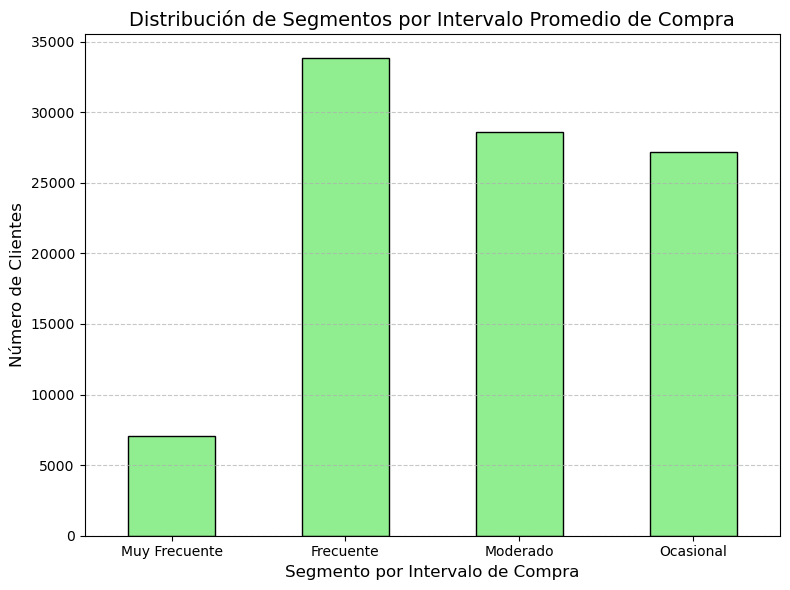

In [23]:
import matplotlib.pyplot as plt

# === Gráfico 1: Segmentación por Frecuencia ===
plt.figure(figsize=(8,6))
customer_segments['freq_segment'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribución de Segmentos por Frecuencia de Compra", fontsize=14)
plt.xlabel("Segmento de Frecuencia", fontsize=12)
plt.ylabel("Número de Clientes", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Gráfico 2: Segmentación por Intervalo de Compra ===
plt.figure(figsize=(8,6))
customer_segments['interval_segment'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribución de Segmentos por Intervalo Promedio de Compra", fontsize=14)
plt.xlabel("Segmento por Intervalo de Compra", fontsize=12)
plt.ylabel("Número de Clientes", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Análisis por producto

### Productos más vendidos

In [8]:

product_dist = exploded_products['product_id'].value_counts()
print("\nTop 10 productos más vendidos:")
print(product_dist.head(10))



Top 10 productos más vendidos:
product_id
5     601052
3     539710
4     520836
8     507798
7     451754
13    370334
14    359268
17    332810
18    332466
26    303588
Name: count, dtype: int64


### Reglas de asociación

Es una técnica de análisis que se usa para encontrar patrones de productos que se venden juntos.

In [4]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

basket = exploded_products.groupby(['customer_id','date','product_id'])['product_id'] \
    .count().unstack().fillna(0)
basket = basket > 0

freq_items = fpgrowth(basket, min_support=0.01, use_colnames=True)
rules = association_rules(freq_items, metric="lift", min_threshold=1)

rules.to_pickle("association_rules.pkl")


print(rules.sort_values("lift", ascending=False).head())


             antecedents      consequents  antecedent support  \
6852914  (16, 9, 20, 22)  (3, 21, 14, 30)            0.020808   
6852891  (3, 21, 14, 30)  (16, 9, 20, 22)            0.029821   
6852907  (9, 20, 21, 14)  (16, 3, 22, 30)            0.023907   
6852898  (16, 3, 22, 30)  (9, 20, 21, 14)            0.025989   
6852903  (16, 9, 20, 14)  (3, 21, 22, 30)            0.024049   

         consequent support  support  confidence       lift  leverage  \
6852914            0.029821   0.0101    0.485369  16.276153  0.009479   
6852891            0.020808   0.0101    0.338673  16.276153  0.009479   
6852907            0.025989   0.0101    0.422457  16.255015  0.009478   
6852898            0.023907   0.0101    0.388603  16.255015  0.009478   
6852903            0.025885   0.0101    0.419962  16.223955  0.009477   

         conviction  zhangs_metric  
6852914    1.885193       0.958505  
6852891    1.480647       0.967409  
6852907    1.686473       0.961466  
6852898    1.596496   

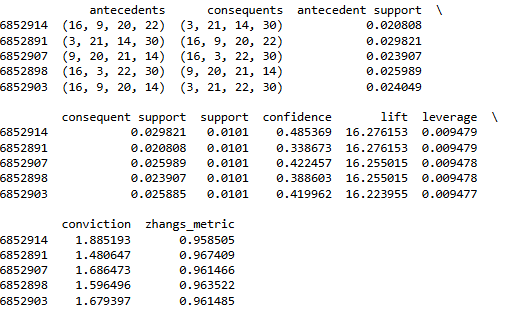

La regla indica que cuando los clientes compran los productos con IDs (16, 9, 20, 22), existe un 48.5%(confidence) de probabilidad de que también compren los productos (3, 21, 14, 30). Además, el lift de 16.27 muestra que esta combinación ocurre 16 veces más de lo esperado al azar

el 1.01% de todas las compras contienen todos los productos del antecedente (16,9,20,22) y del consecuente (3,21,14,30) al mismo tiempo.

In [10]:
print("\n=== Estadísticas globales de las reglas ===")
print(rules[['support','confidence','lift']].describe())

# Top 10 reglas por Lift
print("\n=== Top 10 Lift ===")
print(rules.sort_values("lift", ascending=False)[['antecedents','consequents','support','confidence','lift']].head(10))

# Top 10 reglas por Confidence
print("\n=== Top 10 Confidence ===")
print(rules.sort_values("confidence", ascending=False)[['antecedents','consequents','support','confidence','lift']].head(10))



=== Estadísticas globales de las reglas ===
            support    confidence          lift
count  7.838292e+06  7.838292e+06  7.838292e+06
mean   1.224158e-02  3.354472e-01  6.377278e+00
std    2.834786e-03  2.035986e-01  2.099466e+00
min    1.000000e-02  3.679672e-02  1.077125e+00
25%    1.054193e-02  1.722923e-01  4.779516e+00
50%    1.135529e-02  2.996181e-01  6.378019e+00
75%    1.288067e-02  4.669788e-01  7.822024e+00
max    1.373464e-01  9.804857e-01  1.627615e+01

=== Top 10 Lift ===
             antecedents      consequents   support  confidence       lift
6852914  (16, 9, 20, 22)  (3, 21, 14, 30)  0.010100    0.485369  16.276153
6852891  (3, 21, 14, 30)  (16, 9, 20, 22)  0.010100    0.338673  16.276153
6852907  (9, 20, 21, 14)  (16, 3, 22, 30)  0.010100    0.422457  16.255015
6852898  (16, 3, 22, 30)  (9, 20, 21, 14)  0.010100    0.388603  16.255015
6852903  (16, 9, 20, 14)  (3, 21, 22, 30)  0.010100    0.419962  16.223955
6852902  (3, 21, 22, 30)  (16, 9, 20, 14)  0.010100 

### Recomendador de Productos

Desarrollar un modelo básico de recomendación usando técnicas de filtrado colaborativo o
reglas de asociación:


In [5]:
import pandas as pd
rules = pd.read_pickle("association_rules.pkl")

**Dado un cliente**: sugerir productos complementarios o similares a los que ha
comprado.

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cliente_producto = exploded_products.groupby(['customer_id', 'product_id']).size().unstack(fill_value=0)
cliente_producto = (cliente_producto > 0).astype(int)


def recomendar_por_cliente(cliente_id, top_n=5):
    if cliente_id not in cliente_producto.index:
        return f"Cliente {cliente_id} no encontrado."
    
    cliente_vector = cliente_producto.loc[[cliente_id]]
    
    # Calcular similitud solo contra todos los demás
    similitudes = cosine_similarity(cliente_vector, cliente_producto)[0]
    sim_series = pd.Series(similitudes, index=cliente_producto.index).sort_values(ascending=False)[1:50]
    
    # Clientes similares
    clientes_similares = sim_series.index
    
    # Productos del cliente actual
    productos_cliente = set(cliente_producto.loc[cliente_id][cliente_producto.loc[cliente_id] > 0].index)
    
    # Promedio de compras entre clientes similares
    productos_similares = cliente_producto.loc[clientes_similares]
    productos_prom = productos_similares.mean().sort_values(ascending=False)
    
    # Filtrar productos que el cliente no tiene
    recomendaciones = productos_prom[~productos_prom.index.isin(productos_cliente)].head(top_n)
    
    return list(recomendaciones.index)


In [17]:
def mapear_categorias_productos(product_ids):
    """
    Recibe una lista/Serie de product_id y devuelve sus categorías asociadas.
    """
    mapeo = product_category_df.merge(categories_df, left_on='v.code', right_on='category_id', how='left')
    mapeo = mapeo[['v.Code_pr', 'category_name']].drop_duplicates()
    
    return pd.Series(product_ids).map(dict(zip(mapeo['v.Code_pr'], mapeo['category_name'])))


In [19]:
recomendar_por_cliente(1508)

[21, 3, 19, 24, 25]

In [20]:
mapear_categorias_productos(recomendar_por_cliente(1508))

0                                 NaN
1    VERDURAS RAIZ,TUBERCULO Y BULBOS
2                                 NaN
3                  VERDURAS DE FRUTOS
4                  VERDURAS DE FRUTOS
dtype: object

**Dado un producto**: recomendar otros productos que suelen comprarse junto a él.


In [12]:
def recomendar_por_producto(producto_id, top_n=5):
    """
    Retorna los productos que suelen comprarse junto al producto dado.
    """
    recomendaciones = rules[rules['antecedents'].apply(lambda x: producto_id in x)]
    if recomendaciones.empty:
        return f"No hay reglas disponibles para el producto {producto_id}."
    
    recomendaciones = recomendaciones.sort_values(by='lift', ascending=False).head(top_n)
    return recomendaciones[['antecedents', 'consequents', 'confidence', 'lift']]

In [21]:
recomendar_por_producto(20)

,antecedents,consequents,confidence,lift
6852914,"(16, 9, 20, 22)","(3, 21, 14, 30)",0.485369,16.276153
6852907,"(9, 20, 21, 14)","(16, 3, 22, 30)",0.422457,16.255015
6852903,"(16, 9, 20, 14)","(3, 21, 22, 30)",0.419962,16.223955
4824687,"(16, 9, 20, 14)","(24, 3, 21, 30)",0.422144,16.112275
4824691,"(9, 20, 21, 14)","(16, 24, 3, 30)",0.424652,15.963801


In [24]:
def recomendar_por_producto_unico_antecedente(producto_id, top_n=5):
 
    mask = rules['antecedents'].apply(lambda x: x == frozenset([producto_id]))
    
    recomendaciones = rules[mask]
    
    if recomendaciones.empty:
        return f"No hay reglas disponibles para el producto {producto_id}."
    
    recomendaciones = recomendaciones.sort_values(by='lift', ascending=False).head(top_n)
    return recomendaciones[['antecedents', 'consequents', 'confidence', 'lift']]


In [25]:
recomendar_por_producto_unico_antecedente(20)

,antecedents,consequents,confidence,lift
7684379,(20),"(24, 37, 54)",0.081973,6.467168
7667923,(20),"(24, 21, 54, 30)",0.085226,6.348596
7667256,(20),"(3, 9, 21, 54, 24)",0.078763,6.346150
7674354,(20),"(24, 27, 54)",0.083918,6.326613
7684034,(20),"(37, 21, 54, 30)",0.081874,6.325709
